In [1]:
#Nivel de ruido
n_scans = 1
##inhomogeneidades_var = 'no' #si/no
#BM4D = 'si' #si/no

#Si queremos que quite n slices del principio y fin para evitar imágenes oscuras
#quitar_slices = 4

#Augmentation
#augmentation = 'no' #si/no
#flipleft = "no"
#flipupdown = "no"
#zoom = "no"
vae_model=False

SEED = 50

In [2]:
import tensorflow

C:\Users\usuario\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\usuario\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\usuario\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
import numpy
print(numpy.__version__)

1.24.2


In [4]:
tensorflow.config.experimental.set_memory_growth(tensorflow.config.list_physical_devices('GPU')[0], True)

In [5]:
import scipy.io
import os
#import fastmri
#from fastmri.data import transforms as T
import numpy as np
from matplotlib import pyplot as plt
import random

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization

import math

from skimage.metrics import structural_similarity as ssim

from sklearn.model_selection import train_test_split

from random import randint

import matplotlib.patches as patches
from bm4d import bm4d

import cv2 as cv

from datetime import datetime 
import time

import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\usuario\\Desktop\\TFM\\TFM_ordenador_FER\\physio_MRI\\physio_code\\AE_Physio\\autoencoder\\utils.py'>

In [6]:
os.getcwd()

'C:\\Users\\usuario\\Desktop\\TFM\\TFM_ordenador_FER\\physio_MRI\\physio_code\\AE_Physio\\autoencoder'

## Load Preprocess

In [7]:
x_train = np.load('../save_images/augmentation/n_scans_' + str(n_scans) +'/bm4d_and_no_inhom/x_train.npy')
x_train_noisy = np.load('../save_images/augmentation/n_scans_' + str(n_scans) +'/bm4d_and_no_inhom/x_train_noisy.npy')
x_test = np.load('../save_images/augmentation/n_scans_' + str(n_scans) +'/bm4d_and_no_inhom/x_test.npy')
x_test_noisy = np.load('../save_images/augmentation/n_scans_' + str(n_scans) +'/bm4d_and_no_inhom/x_test_noisy.npy')

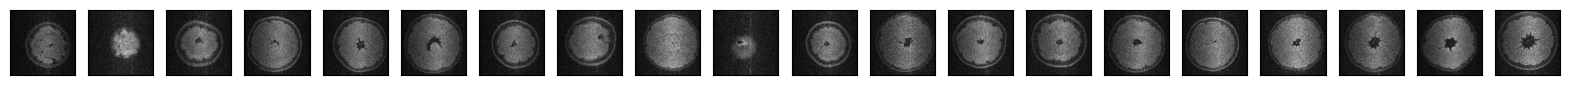

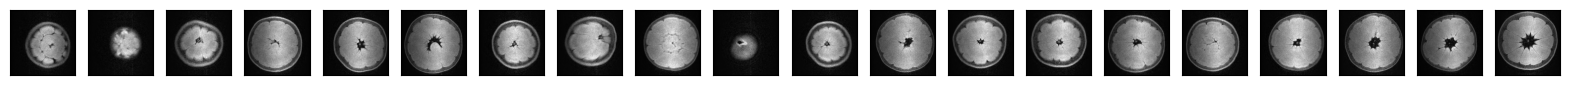

In [8]:
n = 20
z = 20
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i+z].reshape(x_train_noisy.shape[1], x_train_noisy.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i+z].reshape(x_train_noisy.shape[1], x_train_noisy.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Train

In [9]:
import importlib
import modelos_def
import modelos
importlib.reload(modelos_def)
importlib.reload(modelos)

from modelos import modelo_complejo
from tensorflow import stack

from modelos import modelo_yolanda1
from modelos import modelo_yolanda2
from modelos import modelo_yolanda3

from modelos import REDnet
from modelos import skip_conection
from modelos import skip_conection_simple
from modelos import skip_conection_simple_inhom

from modelos_def import skip_conection_pruebas
from modelos_def import dn_cnn
from modelos_def import vae_definitive

from modelos_def import resnet

In [10]:
#10% from train Validation
x_train, x_val = train_test_split(x_train,
                                   test_size=0.1,
                                   random_state=SEED)

x_train_noisy, x_val_noisy = train_test_split(x_train_noisy,
                                   test_size=0.1,
                                   random_state=SEED)

print("nº images train: ", x_train.shape)
print("nº images val: ", x_val.shape)
print("nº images test: ", x_test.shape)
print(x_train_noisy.shape)
print(x_val_noisy.shape)
print(x_test_noisy.shape)

nº images train:  (518, 160, 160, 1)
nº images val:  (58, 160, 160, 1)
nº images test:  (36, 160, 160, 1)
(518, 160, 160, 1)
(58, 160, 160, 1)
(36, 160, 160, 1)


In [11]:
input_img = tensorflow.keras.Input(shape=(x_train.shape[1], x_train.shape[1], 1))
print(input_img.shape)

decoded = resnet(input_img)

autoencoder = tensorflow.keras.Model(input_img, decoded)

(None, 160, 160, 1)


In [12]:
#Para guardar las épocas al reentrenar
loss_list_def = []
val_loss_list_def = []
epoch_list_def = []

In [13]:
# Loss functtion
def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim(y_true, y_pred, 1.0))

In [14]:
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#autoencoder.compile(optimizer='adam', loss='mse')
#optimizer=tensorflow.keras.optimizers.SGD()
optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
#optimizer='adam'
autoencoder.compile(optimizer=optimizer, loss=ssim_loss)#, metrics=[ssim_loss, 'accuracy'])

In [15]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 160, 160, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [16]:
#Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        lr=0.0001
    return lr
    
scheduler_callback = tensorflow.keras.callbacks.LearningRateScheduler(scheduler)
#return lr * tensorflow.math.exp(-0.1)

In [17]:
#lr=0.001
#for i in range(30):
#    lr=lr * tensorflow.math.exp(-0.1)
#    print(lr)

In [18]:
#Guardar cada 3 épocas los pesos
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath='autoencoders_keras_physio_MRI_weights/save_weights_3_epocs/pesos_modelo_{epoch:08d}.h5',
    save_weights_only=True
)

In [19]:
loss_list = []
val_loss_list = []
epoch_list = []
class CustomCallback(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Obtener el valor de pérdida actual
        loss = logs['loss']
        val_loss = logs['val_loss']

        # Agregar el valor de pérdida y el número de épocas a las listas
        loss_list.append(loss)
        val_loss_list.append(val_loss)
        epoch_list.append(epoch + 1)

In [20]:
#Time predict
start_time = datetime.now() 

epocas = 30

batch_size = 1

autoencoder_train = autoencoder.fit(x_train_noisy, x_train,
                epochs= epocas,
                batch_size= batch_size,
                shuffle=True,
                validation_data=(x_val_noisy, x_val),
                callbacks=[CustomCallback(), checkpoint_callback])

#Time predict
print(" ")
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Epoch 1/30
518/518 [==============================] - 369s 698ms/step - loss: 0.3883 - val_loss: 0.5525
Epoch 2/30
518/518 [==============================] - 362s 699ms/step - loss: 0.2947 - val_loss: 0.3561
Epoch 3/30
518/518 [==============================] - 362s 699ms/step - loss: 0.2604 - val_loss: 0.2430
Epoch 4/30
518/518 [==============================] - 361s 698ms/step - loss: 0.2542 - val_loss: 0.2285
Epoch 5/30
518/518 [==============================] - 362s 698ms/step - loss: 0.2360 - val_loss: 0.2063
Epoch 6/30
518/518 [==============================] - 362s 699ms/step - loss: 0.2311 - val_loss: 0.2110
Epoch 7/30
518/518 [==============================] - 362s 699ms/step - loss: 0.2283 - val_loss: 0.2078
Epoch 8/30
518/518 [==============================] - 362s 699ms/step - loss: 0.2218 - val_loss: 0.3895
Epoch 9/30
518/518 [==============================] - 362s 700ms/step - loss: 0.2138 - val_loss: 0.1939
Epoch 10/30
518/518 [==============================] - 362s 699m

KeyboardInterrupt: 

In [21]:
#Para guardar las épocas al reentrenar
loss_list_def.extend(loss_list[:])
val_loss_list_def.extend(val_loss_list[:])
epoch_list_def.append(epoch_list[-1])
epochs = range(np.sum(epoch_list_def))

C:\Users\usuario\AppData\Local\Temp\ipykernel_8584\3444324714.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss_list_def, 'bo', color='#006699', label='Training loss')
C:\Users\usuario\AppData\Local\Temp\ipykernel_8584\3444324714.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss_list_def, 'b', color='#006699', label='Validation loss')


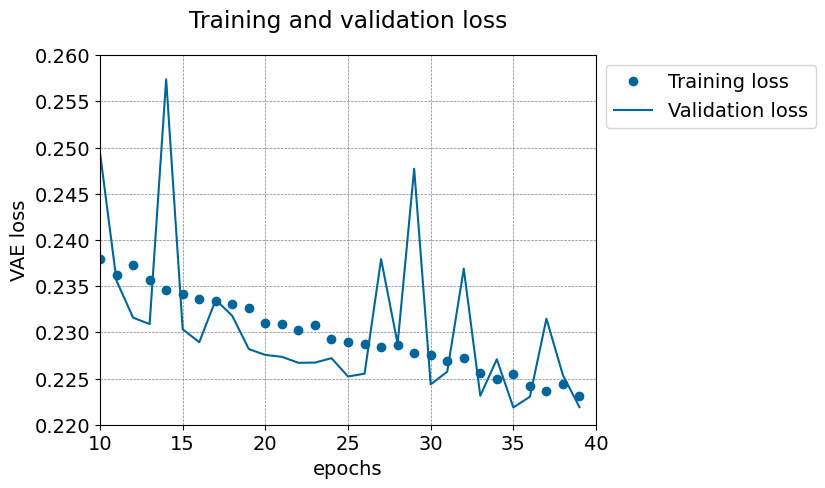

In [11]:
plt.figure()
plt.rcParams.update({'font.size': 14})
plt.plot(epochs, loss_list_def, 'bo', color='#006699', label='Training loss')
plt.plot(epochs, val_loss_list_def, 'b', color='#006699', label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('SSIM loss')
plt.title('Training and validation loss', pad = 20)
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('white')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlim(10, 40)
plt.ylim(0.22, 0.26)
plt.show()

In [23]:
print(optimizer)
print(batch_size)

print(loss_list)
print(val_loss_list)
print(epoch_list)

1
[0.3883160352706909, 0.294710636138916, 0.2603686451911926, 0.25418904423713684, 0.23602044582366943, 0.23111455142498016, 0.22832319140434265, 0.22176781296730042, 0.21377328038215637, 0.20584949851036072, 0.20139211416244507, 0.20202940702438354, 0.19991561770439148, 0.1970963478088379, 0.19053810834884644, 0.18868388235569]
[0.5524516105651855, 0.35614001750946045, 0.24296711385250092, 0.22850656509399414, 0.20633438229560852, 0.21095982193946838, 0.20779070258140564, 0.38945290446281433, 0.19394005835056305, 0.2006627321243286, 0.2831898629665375, 0.205941841006279, 0.24704091250896454, 0.19324932992458344, 0.2700156271457672, 0.3632011413574219]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [24]:
#raise

## Save

In [25]:
#path_load_save='autoencoders_keras_physio_MRI_weights/dae_skip_128_batch_norm_lr/pesos_modelo_00000060.h5'
path_load_save='autoencoders_keras_physio_MRI_weights/save_weights_3_epocs/pesos_modelo_00000011.h5'
#path_load_save='autoencoders_keras_physio_MRI_weights/dncnn_64/dncnn_mejorado.h5'

In [26]:
#autoencoder.save_weights('autoencoders_keras_physio_MRI_weights/autoencoder_mri')
#autoencoder.save_weights(path_load_save)
#autoencoder.save_weights('autoencoders_keras_physio_MRI_weights/dn_cnn')

In [27]:
#Clear TF memory
tensorflow.keras.backend.clear_session() #to release all TF memory

In [28]:
autoencoder = tensorflow.keras.Model(input_img, decoded)

In [29]:
#autoencoder.load_weights(path_load_save)

## Predict

In [30]:
#PREDICCION BUENA
#Time predict
start_time = datetime.now() 
decoded_imgs = autoencoder.predict(x_test_noisy, batch_size=1)
#Time predict
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:00:09.517108


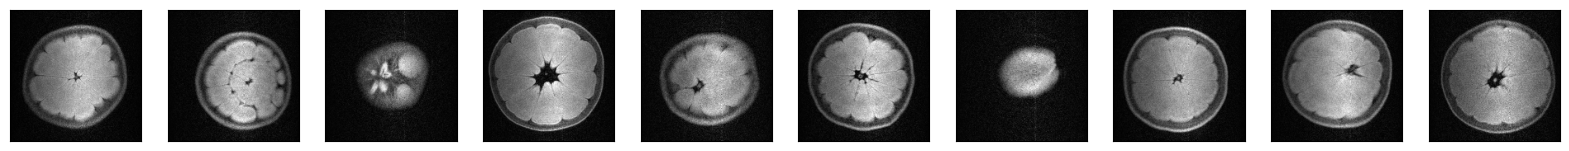

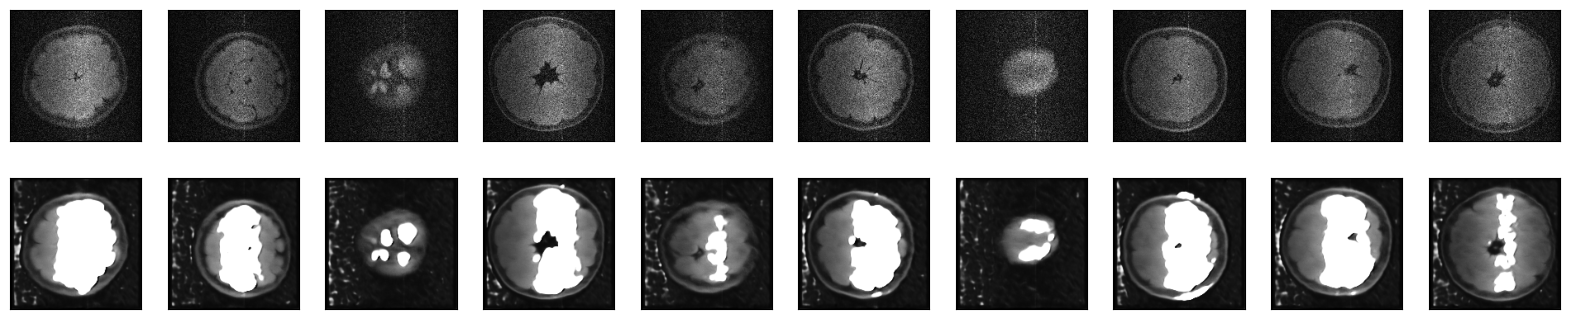

In [31]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original 
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test[i].reshape(x_train.shape[1], x_train.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original noise
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(x_train.shape[1], x_train.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(x_train.shape[1], x_train.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

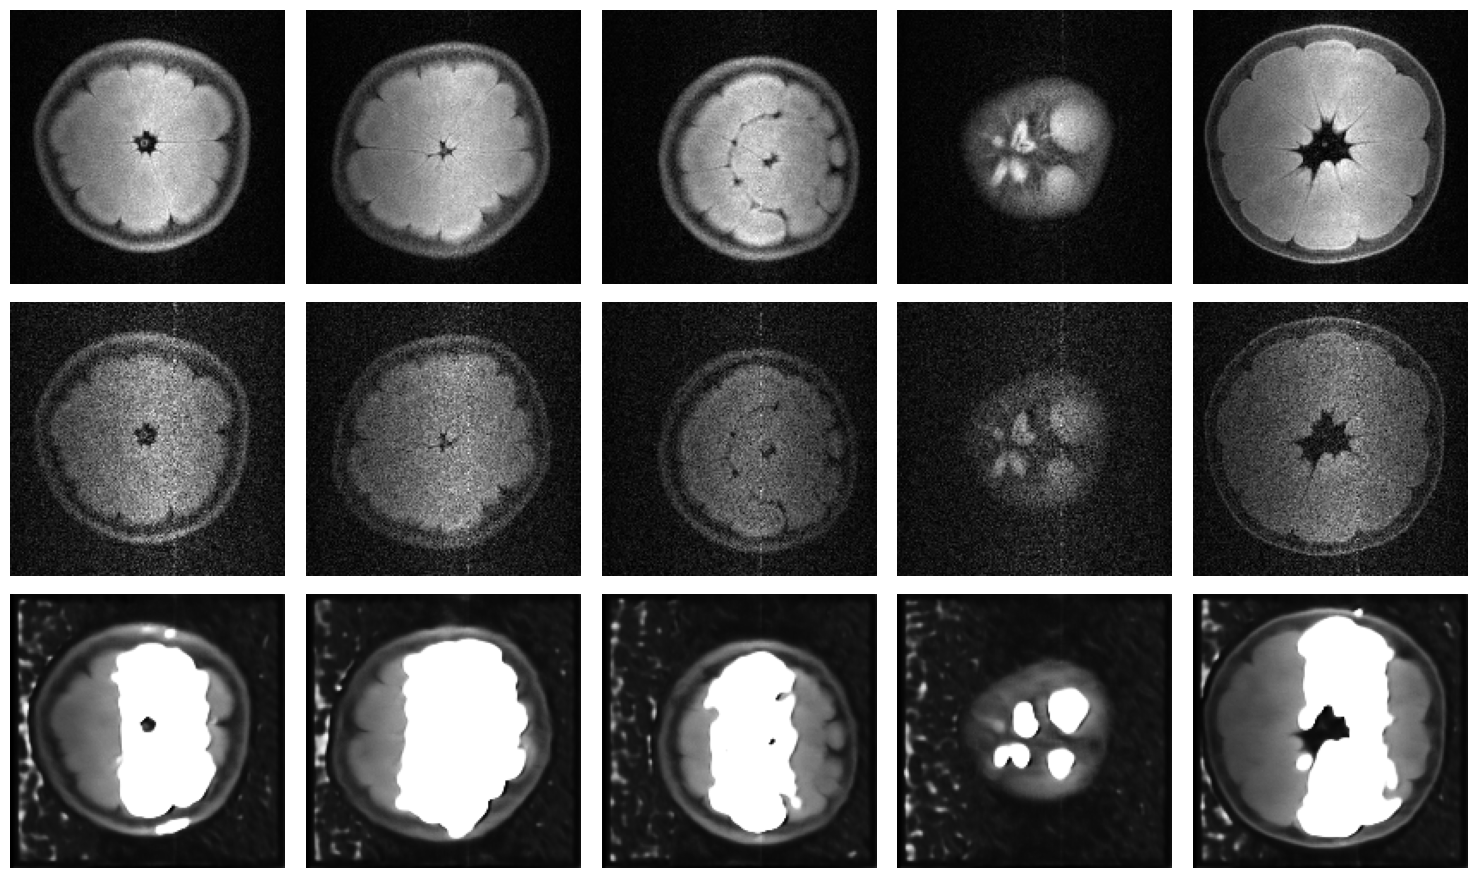

In [32]:
utils.show_image(x_test, x_test_noisy, decoded_imgs)

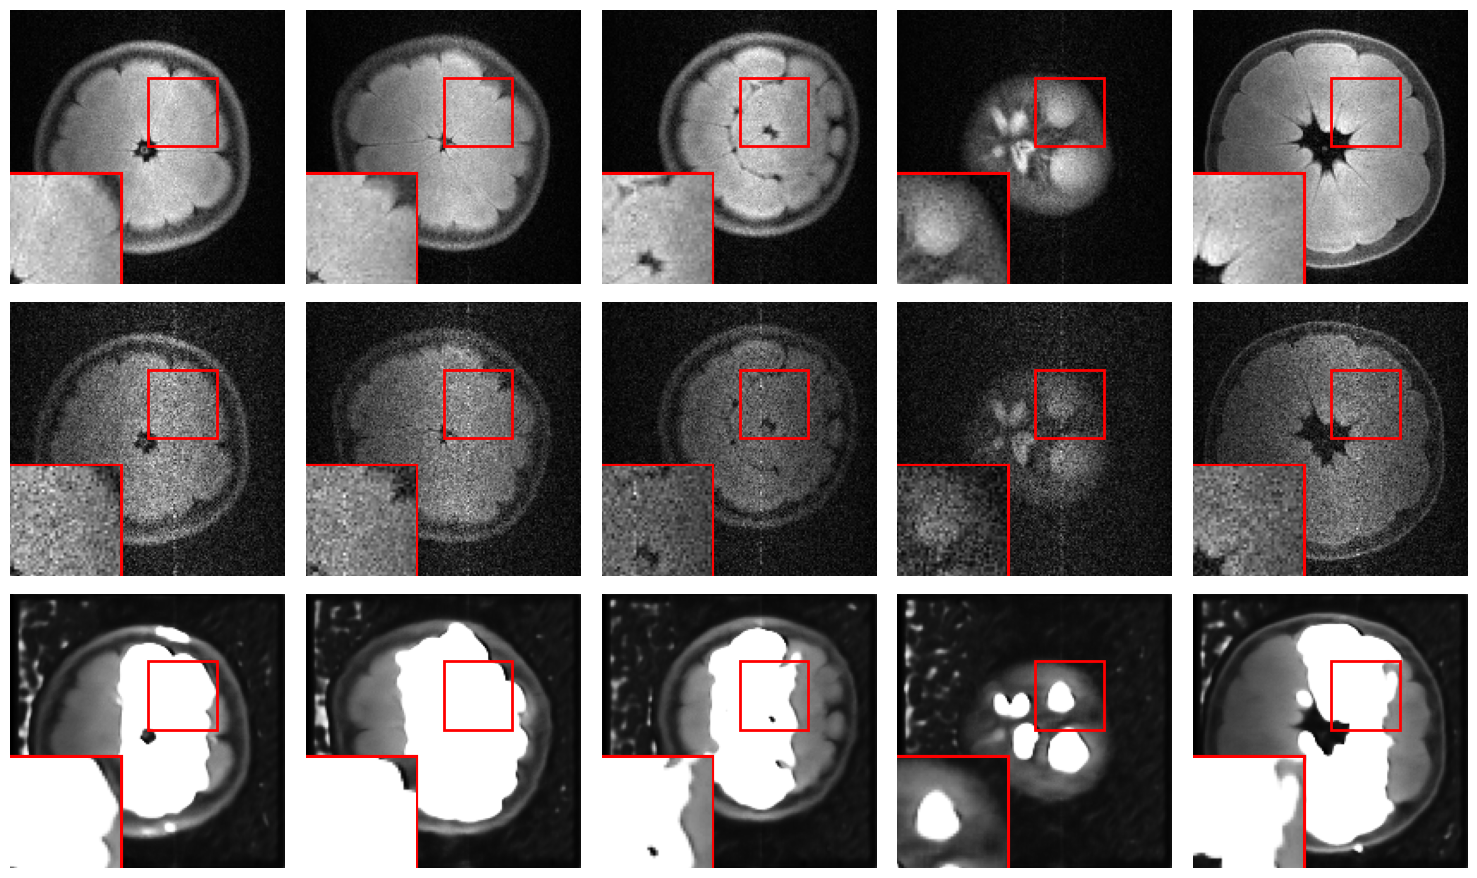

In [33]:
utils.show_windows_image(x_test, x_test_noisy, decoded_imgs)

## Métricas

In [34]:
#PSNR
from skimage.metrics import peak_signal_noise_ratio as psnr
psnr_general=0
psnr_noise_hist=[]
for i in list(range(x_test.shape[0])):
    psnr_noise = psnr(x_test[i,:,:,0], decoded_imgs[i,:,:,0])
    psnr_noise_hist.append(psnr_noise)
    psnr_general=psnr_general+psnr_noise

mean_psnr = psnr_general/x_test.shape[0]

#std PSNR
sum_std = []
for i in list(range(x_test.shape[0])):
    psnr_noise = psnr(x_test[i,:,:,0], decoded_imgs[i,:,:,0])
    psnr_noise_mean = (psnr_noise - mean_psnr)**2
    sum_std.append(psnr_noise_mean)

psnr_std = (np.sum(psnr_noise_mean)/x_test.shape[0])**0.5
print('PSNR: '+ str(mean_psnr) + " +- " + str(psnr_std))


#SSIM
from skimage.metrics import structural_similarity as ssim
ssim_general=0
ssim_noise_hist=[]

#Compute the mean structural similarity index between two images.
for i in list(range(x_test.shape[0])):
    ssim_noise = ssim(x_test[i,:,:,0], decoded_imgs[i,:,:,0],
                  data_range=decoded_imgs[i,:,:,0].max() - decoded_imgs[i,:,:,0].min())
    ssim_noise_hist.append(ssim_noise)
    ssim_general=ssim_general+ssim_noise
    
mean_ssim = ssim_general/x_test.shape[0]

#std SSIM
sum_std = []
for i in list(range(x_test.shape[0])):
    ssim_noise = ssim(x_test[i,:,:,0], decoded_imgs[i,:,:,0],
                  data_range=decoded_imgs[i,:,:,0].max() - decoded_imgs[i,:,:,0].min())
    ssim_noise_mean = (ssim_noise - mean_ssim)**2
    sum_std.append(ssim_noise_mean)
    
ssim_std = (np.sum(ssim_noise_mean)/x_test.shape[0])**0.5
print("SSIM: "+ str(mean_ssim) + " +- " + str(ssim_std))

PSNR: 13.61079904951492 +- 0.1406421708159368
SSIM: 0.4697872995413204 +- 0.005397079351804233


C:\Users\usuario\AppData\Local\Temp\ipykernel_4916\2183798020.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_noise = psnr(x_test[i,:,:,0], decoded_imgs[i,:,:,0])
C:\Users\usuario\AppData\Local\Temp\ipykernel_4916\2183798020.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_noise = psnr(x_test[i,:,:,0], decoded_imgs[i,:,:,0])


In [35]:
###################BORRAR############################

In [ ]:
################FIN BORRAR##########################

In [ ]:
x_test.shape

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.hist(ssim_noise_hist, color='#006699', edgecolor='black', linewidth=1.2)
plt.xlabel('SSIM')
plt.ylabel('nº imágenes')
plt.title('SSIM n_scans = ' +  str(n_scans), pad = 20)
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('white')
plt.show()

plt.rcParams.update({'font.size': 14})
plt.hist(psnr_noise_hist, color='#006699', edgecolor='black', linewidth=1.2)
plt.xlabel('PSNR')
plt.ylabel('nº imágenes')
plt.title('PSNR n_scans = ' +  str(n_scans), pad = 20)
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('white')
plt.show()

In [ ]:
hist_sort_values=np.sort(ssim_noise_hist)
hist_sort_index=np.argsort(ssim_noise_hist)

hist_sort_values_psnr=np.sort(psnr_noise_hist)
hist_sort_index_psnr=np.argsort(psnr_noise_hist)

**worst ssim and psnr**

In [ ]:
worst_ssim=hist_sort_index[:5]
worst_psnr=hist_sort_index_psnr[:5]

In [ ]:
worst_ssim

In [ ]:
print(hist_sort_values[:5])
print(hist_sort_values_psnr[:5])

In [ ]:
n = 5
plt.figure(figsize=(20, 4))

j=0
for i,j in zip(worst_ssim, range(1, n + 1)):
    # Display original 
    ax = plt.subplot(2, n, j + n)
    plt.imshow(x_test[i].reshape(x_test.shape[1], x_test.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

n = 5
plt.figure(figsize=(20, 4))
for i,j in zip(worst_ssim, range(1, n + 1)):
    # Display original noise
    ax = plt.subplot(2, n, j)
    plt.imshow(x_test_noisy[i].reshape(x_test.shape[1], x_test.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(2, n, j + n)
    plt.imshow(decoded_imgs[i].reshape(x_test.shape[1], x_test.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
utils.show_image_worstbest(x_test, x_test_noisy, decoded_imgs, worst_ssim)

In [ ]:
utils.show_windows_image_worstbest(x_test, x_test_noisy, decoded_imgs, worst_ssim)

In [ ]:
n = 5
plt.figure(figsize=(20, 4))

j=0
for i,j in zip(worst_psnr, range(1, n + 1)):
    # Display original 
    ax = plt.subplot(2, n, j + n)
    plt.imshow(x_test[i].reshape(x_test.shape[1], x_test.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

n = 5
plt.figure(figsize=(20, 4))
for i,j in zip(worst_psnr, range(1, n + 1)):
    # Display original noise
    ax = plt.subplot(2, n, j)
    plt.imshow(x_test_noisy[i].reshape(x_test.shape[1], x_test.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(2, n, j + n)
    plt.imshow(decoded_imgs[i].reshape(x_test.shape[1], x_test.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
utils.show_image_worstbest(x_test, x_test_noisy, decoded_imgs, worst_psnr)

In [ ]:
utils.show_windows_image_worstbest(x_test, x_test_noisy, decoded_imgs, worst_psnr)

**best SSIM**

In [ ]:
best_ssim=hist_sort_index[len(hist_sort_index)-5:len(hist_sort_index)]
best_psnr=hist_sort_index_psnr[len(hist_sort_index_psnr)-5:len(hist_sort_index_psnr)]

In [ ]:
print(hist_sort_values[len(hist_sort_values)-5:len(hist_sort_values)])
print(hist_sort_values_psnr[len(hist_sort_values_psnr)-5:len(hist_sort_values_psnr)])

In [ ]:
n = 5
plt.figure(figsize=(20, 4))

j=0
for i,j in zip(best_ssim, range(1, n + 1)):
    # Display original 
    ax = plt.subplot(2, n, j + n)
    plt.imshow(x_test[i].reshape(x_test.shape[1], x_test.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

n = 5
plt.figure(figsize=(20, 4))
for i,j in zip(best_ssim, range(1, n + 1)):
    # Display original noise
    ax = plt.subplot(2, n, j)
    plt.imshow(x_test_noisy[i].reshape(x_test.shape[1], x_test.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    
    # Display reconstruction
    ax = plt.subplot(2, n, j + n)
    plt.imshow(decoded_imgs[i].reshape(x_test.shape[1], x_test.shape[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
utils.show_image_worstbest(x_test, x_test_noisy, decoded_imgs, best_ssim)

In [ ]:
utils.show_windows_image_worstbest(x_test, x_test_noisy, decoded_imgs, best_ssim)

In [ ]:
    n = 5
    plt.figure(figsize=(20, 4))

    j=0
    for i,j in zip(best_psnr, range(1, n + 1)):
        # Display original 
        ax = plt.subplot(2, n, j + n)
        plt.imshow(x_test[i].reshape(x_test.shape[1], x_test.shape[1]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    n = 5
    plt.figure(figsize=(20, 4))
    for i,j in zip(best_psnr, range(1, n + 1)):
        # Display original noise
        ax = plt.subplot(2, n, j)
        plt.imshow(x_test_noisy[i].reshape(x_test.shape[1], x_test.shape[1]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)



        # Display reconstruction
        ax = plt.subplot(2, n, j + n)
        plt.imshow(decoded_imgs[i].reshape(x_test.shape[1], x_test.shape[1]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
utils.show_image_worstbest(x_test, x_test_noisy, decoded_imgs, best_psnr)

In [ ]:
utils.show_windows_image_worstbest(x_test, x_test_noisy, decoded_imgs, best_psnr)